<a href="https://colab.research.google.com/github/saogregl/SEM5928---Sistemas-de-Controle-2021-/blob/main/Tarefa1_Lucas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install control 

     |████████████████████████████████| 348kB 7.8MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=7652cc208bf2d8a8107a0b574d66cfc5218f9479ce22d8951877c6514652d7f8
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [ ]:
import numpy as np
import control
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal


# Variaveis de entrada fornecidas pelo artigo.
# Irei utilizar a notação completa para facilitar a leitura.

bodyInertia        =    3443.05  #[kg.m^2] Ip
driverMass         =    75.0     #[kg]     Mp1
frontAxleMass      =    87.15    #[kg]     Mt1
frontMainStiffness =    66824.2  #[N/m]    k1
rearMainStiffness  =    18615.0  #[N/m]    k2
frontSeatStiffness =    14000.0  #[N/m]    kp1
rearSeatStiffness  =    14000.0  #[N/m]    kp2
frontTireStiffness =    101115.0 #[N/m]    kt1
rearTireStiffness  =    101115.0 #[N/m]    kt2
b1                 =    1.271    #[m]
d1                 =    0.481    #[m]
bodyMass           =    1794.4   #[kg]     m
passengerMass      =    75       #[kg]     mp2
rearAxleMass       =    140.04   #[kg]     mt2
fmDamping          =    1190.0   #[N.s/m]  c1
rmDamping          =    1000.0   #[N.s/m]  c2
fsDamping          =    50.02    #[N.s/m]  cp1
rsDamping          =    62.1     #[N.s/m]  cp2
ftDamping          =    14.6     #[N.s/m]  ct1
rtDamping          =    14.6     #[N.s/m]  ct2
b2                 =    1.713    #[m]
d2                 =    1.313    #[m]


#Coeficientes da matriz A;

#Primeira equação: x_ddot
a1_x         =   -(1/bodyMass)*(frontMainStiffness + rearMainStiffness + frontSeatStiffness + rearSeatStiffness)
a1_theta     =   -(1/bodyMass)*(frontMainStiffness*b1 - rearMainStiffness*b2  +  frontSeatStiffness*d1 - rearSeatStiffness*d2 )
a1_xp1       =   frontSeatStiffness/bodyMass
a1_xp2       =   rearSeatStiffness/bodyMass
a1_xt1       =   frontMainStiffness/bodyMass
a1_xt2       =   rearMainStiffness/bodyMass
a1_xp1dot    =   fsDamping/bodyMass
a1_xp2dot    =   rsDamping/bodyMass
a1_xt1dot    =   fmDamping/bodyMass
a1_xt2dot    =   rmDamping/bodyMass
a1_xdot      =   -(1/bodyMass)*(fmDamping  +  rmDamping  +  fsDamping  +  rsDamping)
a1_thetadot  =   -(1/bodyMass)*(fmDamping*b1 -rmDamping*b2  + fsDamping*d1 -rsDamping*d2)

#Segunda equação: theta_ddot
a2_x        =   -(1/bodyInertia) * (frontMainStiffness*b1 -rearMainStiffness*b2  + frontSeatStiffness*d1 -rearSeatStiffness*d2 )
a2_theta    =   -(1/bodyInertia) * (frontMainStiffness*b1**2  +  rearMainStiffness*b2**2  +  frontSeatStiffness*d1**2  + rearSeatStiffness*d2**2 )
a2_xp1      =   -(1/bodyInertia) * frontSeatStiffness*d1
a2_xp2      =   (1/bodyInertia) * rearSeatStiffness*d2
a2_xt1      =   -(1/bodyInertia) * frontMainStiffness*b1
a2_xt2      =   (1/bodyInertia) * rearMainStiffness*b2
a2_xdot     =   -(1/bodyInertia)*(fmDamping*b1 -rmDamping*b2  + fsDamping*d1 -rsDamping*d2)
a2_thetadot =   -(1/bodyInertia)*(fmDamping*b1**2  + rmDamping*b2**2  + fsDamping*d1**2  + rsDamping*d2**2)
a2_xp1dot   =   -(1/bodyInertia) * fsDamping*d1
a2_xp2dot   =   (1/bodyInertia) * rsDamping*d2
a2_xt1dot   =   -(1/bodyInertia) * fmDamping*b1
a2_xt2dot   =   (1/bodyInertia) * rmDamping*b2

#Terceira equação: xp1_ddot
a3_x        =   (1/driverMass)*frontSeatStiffness
a3_theta    =   (1/driverMass)*frontSeatStiffness*d1
a3_xp1      =   -(1/driverMass)*frontSeatStiffness
a3_xdot     =   (1/driverMass)*fsDamping
a3_thetadot =   (1/driverMass)*fsDamping*d1
a3_xp1dot   =   -(1/driverMass)*fsDamping

#Quarta equação: xp2_ddot
a4_x        =   (1/passengerMass)*rearSeatStiffness
a4_theta    =   -(1/passengerMass)*rearSeatStiffness*d2
a4_xp2      =   -(1/passengerMass)*rearSeatStiffness
a4_xdot     =   (1/passengerMass)*rsDamping
a4_thetadot =   -(1/passengerMass)*rsDamping*d2
a4_xp2dot  =   -(1/passengerMass)*rsDamping

#Quinta equação: xt1_ddot
a5_x        =   (1/frontAxleMass)*frontMainStiffness
a5_theta    =   (1/frontAxleMass)*frontMainStiffness*b1
a5_xt1      =   -(1/frontAxleMass)*(frontMainStiffness  +  frontTireStiffness)
a5_y1       =   (1/frontAxleMass) * frontTireStiffness
a5_xdot     =   (1/frontAxleMass)*fmDamping
a5_thetadot =   (1/frontAxleMass)*fmDamping*b1
a5_xt1dot   =   -(1/frontAxleMass)*(fmDamping  +  ftDamping)
a5_y1dot    =   (1/frontAxleMass)*ftDamping

#Sexta equação: xt1_ddot
a6_x        =   (1/rearAxleMass) * rearMainStiffness
a6_theta    =   -(1/rearAxleMass)  * rearMainStiffness*b2
a6_xt2      =   -(1/rearAxleMass) * (rearMainStiffness  +  rearTireStiffness)
a6_y2       =   (1/rearAxleMass)  * rearTireStiffness
a6_xdot     =   (1/rearAxleMass)  * rmDamping
a6_thetadot =   -(1/rearAxleMass) * rmDamping*b2
a6_xt2dot   =   -(1/rearAxleMass) * (rmDamping  +  rtDamping)
a6_y2dot     =   (1/rearAxleMass)  * rtDamping

#matriz A



A = np.array([[ 0,    0,         0,     0,      0,      0,      1,       0,           0,         0,         0,  0],
              [ 0,    0,         0,     0,      0,      0,      0,       1,           0,         0,         0,  0],
              [ 0,    0,         0,     0,      0,      0,      0,       0,           1,         0,         0,  0],
              [ 0,    0,         0,     0,      0,      0,      0,       0,           0,         1,         0,  0],
              [ 0,    0,         0,     0,      0,      0,      0,       0,           0,         0,         1,  0],
              [ 0,    0,         0,     0,      0,      0,      0,       0,           0,         0,         0,  1],
              [ a1_x, a1_theta, a1_xp1, a1_xp2, a1_xt1, a1_xt2, a1_xdot, a1_thetadot, a1_xp1dot, a1_xp2dot, a1_xt1dot, a1_xt2dot],
              [ a2_x, a2_theta, a2_xp1, a2_xp2, a2_xt1, a2_xt2, a2_xdot, a2_thetadot, a2_xp1dot, a2_xp2dot, a2_xt1dot, a2_xt2dot],
              [ a3_x, a3_theta, a3_xp1, 0,      0,      0,      a3_xdot, a3_thetadot, a3_xp1dot, 0,         0,          0],
              [ a4_x, a4_theta, 0,      a4_xp2, 0,      0,      a4_xdot, a4_thetadot, 0,         a4_xp2dot, 0,          0],
              [ a5_x, a5_theta, 0,      0,      a5_xt1, 0,      a5_xdot, a5_thetadot, 0,         0,         a5_xt1dot,  0],
              [ a6_x, a6_theta, 0,      0,      0,      a6_xt2, a6_xdot, a6_thetadot, 0,         0,         0,         a6_xt2dot]])


B = np.array([[0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [1/bodyMass, 1/bodyMass],
              [b1/bodyInertia, -b2/bodyInertia],
              [0, 0],
              [0, 0],
              [-1/frontAxleMass, 0],
              [0, -1/rearAxleMass]])


G =  np.array([[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [a5_y1, 0, a5_y1dot, 0],
              [0, a6_y2, 0, a6_y2dot]])


#matriz C
C = np.array([[1,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0,0,0]])

#matriz D
D = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0]])


#Concatenando as matrizes B e G para para ter uma equação da forma x_dot = Ax+Bu

SS_B = np.concatenate((B,G), axis=1)

#Definindo o sistema MIMO. 
sys1 = control.ss(A,SS_B,C,D)








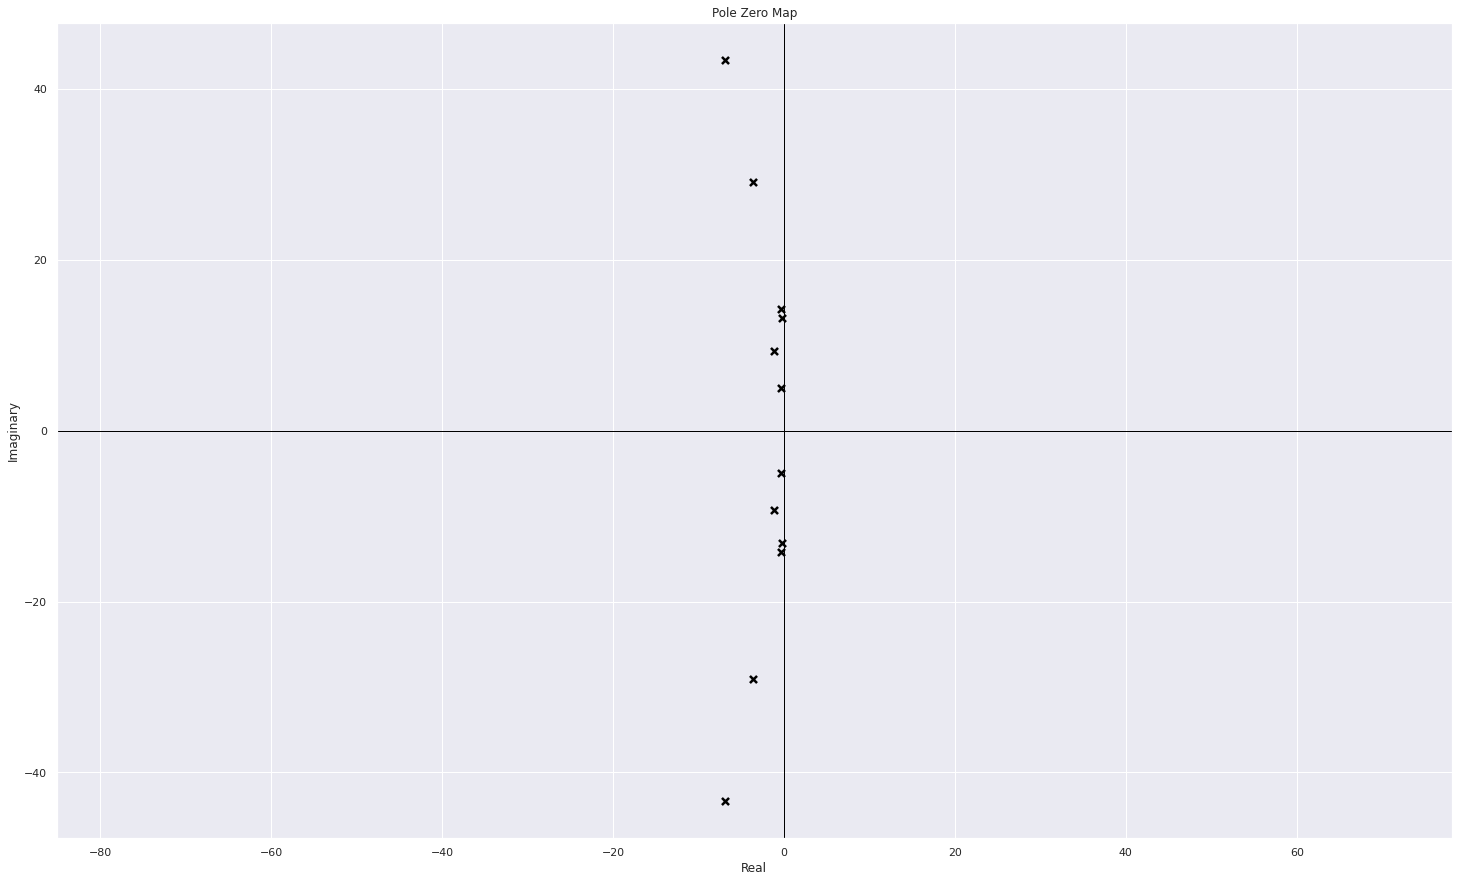

In [ ]:
#plotando mapa de polos e zeros. 

#Irei utilizar um estilo básico da biblioteca seaborn para plotar os gráficos.

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})



plt.figure(figsize = (25,15))
poles, zeros = control.pzmap(sys1, plot = True)

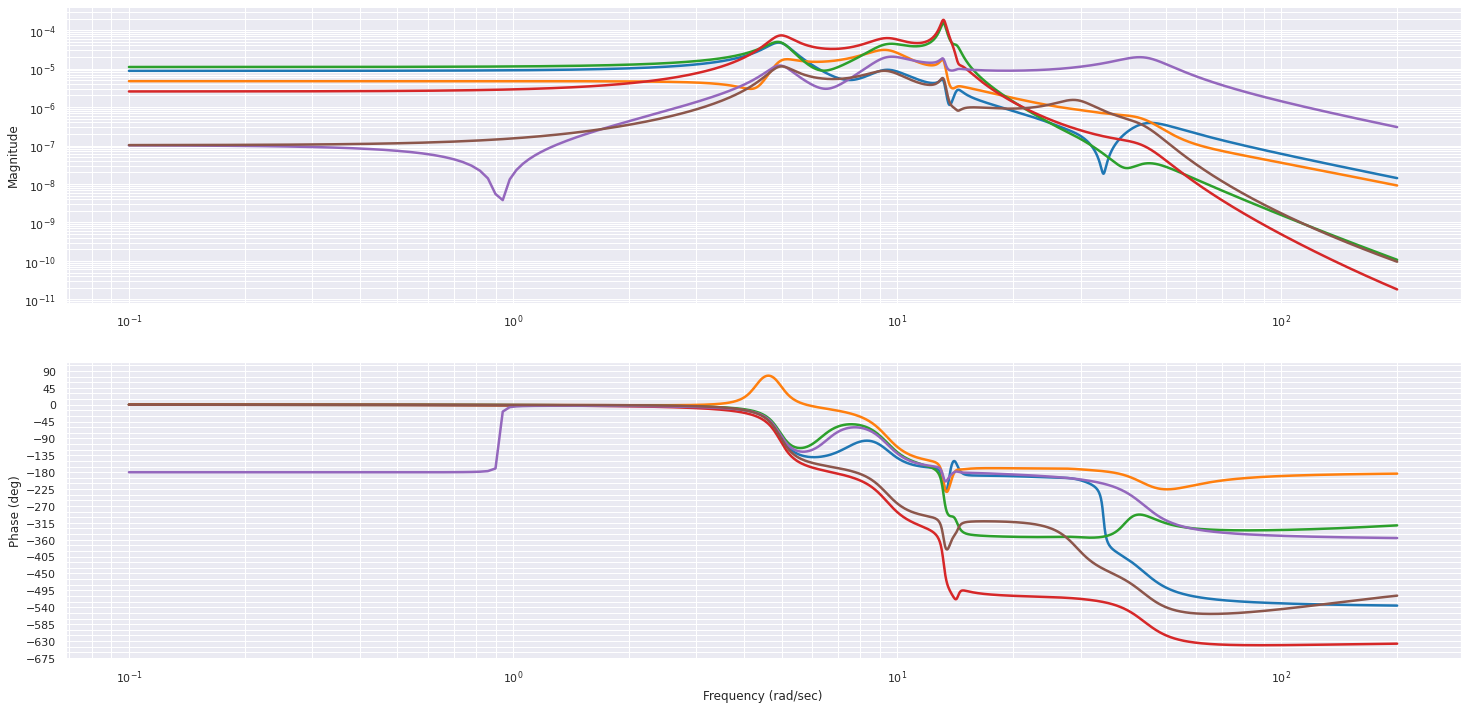

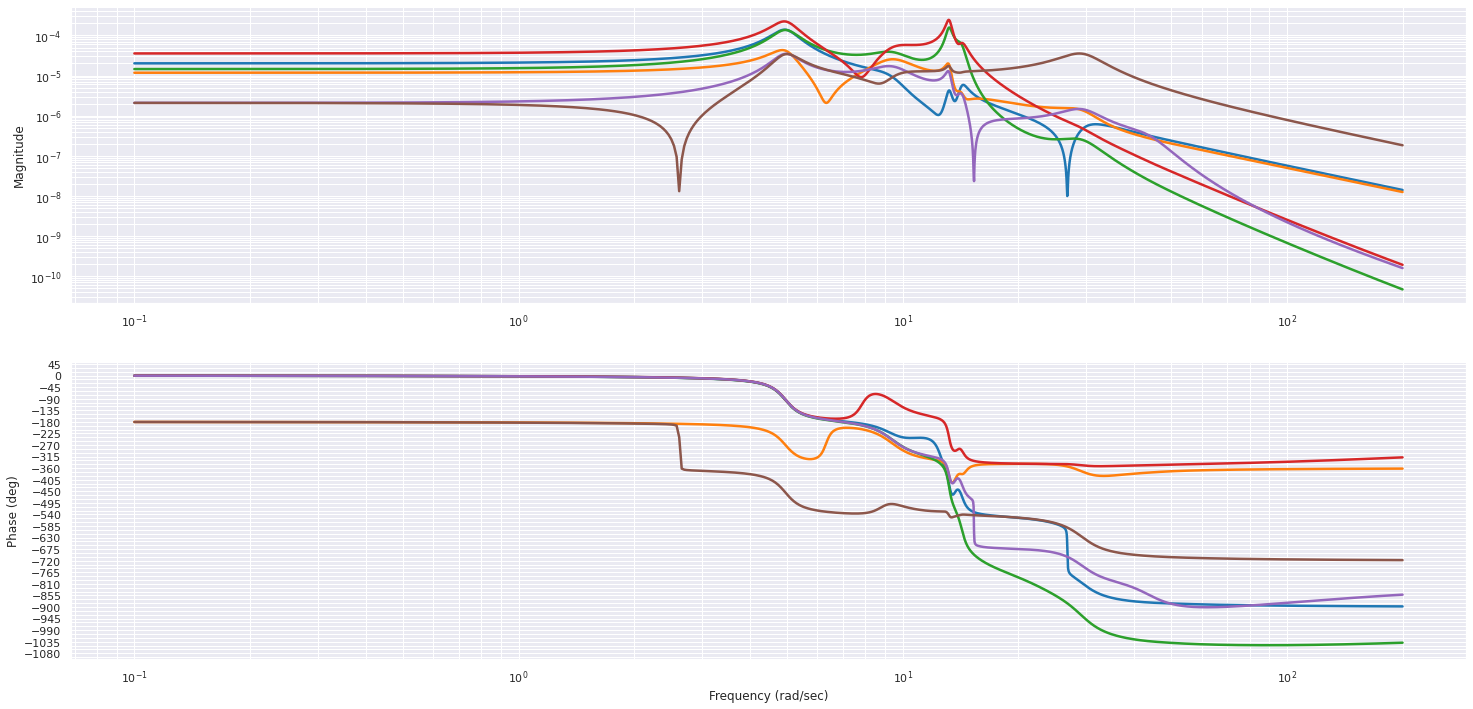

In [ ]:

##Análise da resposta do sistema aos atuadores no tempo e na frequência. 
#Para analisar separadamente cada FT, iremos definir diversos sistemas com 
#somente uma entrada e saída, assumindo que as restantes são nulas. 

#Para cada uma das saídas, podemos definir o vetor C:
C1 = C[0, :] # q1
C2 = C[1, :] # q2
C3 = C[2, :] # q3
C4 = C[3, :] # q4
C5 = C[4, :] # q5
C6 = C[5, :] # q6


#para cada uma das entradas dos atuadores:
B1 = SS_B[:,0]
B2 = SS_B[:,1]

#Para cada uma das entradas de deslocamento impostas pela estrada. 
B3 = SS_B[:,2]
B4 = SS_B[:,4]


D0 = np.array([[0.0]])

#Em relação à entrada 1; 
sys1_q1f1 =  control.ss(A,B1,C1,D0)
sys1_q2f1 = control.ss(A,B1,C2,D0)
sys1_q3f1 = control.ss(A,B1,C3,D0)
sys1_q4f1 = control.ss(A,B1,C4,D0)
sys1_q5f1 = control.ss(A,B1,C5,D0)
sys1_q6f1 = control.ss(A,B1,C6,D0)

sys1_q1f2 =  control.ss(A,B2,C1,D0)
sys1_q2f2 = control.ss(A,B2,C2,D0)
sys1_q3f2 = control.ss(A,B2,C3,D0)
sys1_q4f2 = control.ss(A,B2,C4,D0)
sys1_q5f2 = control.ss(A,B2,C5,D0)
sys1_q6f2 = control.ss(A,B2,C6,D0)

#Vetor de omega.
w = np.linspace(0.1,200,5000)

#q1,q2,q3,q4,q5,q6 = x, theta, xp1, xp2, xt1, xt2,

#Diagramas de bode para cada uma das saídas em função da entrada f1. 
plt.figure(figsize = (25,12))
mag, phase, omega = control.bode_plot(sys1_q1f1,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q2f1,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q3f1,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q4f1,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q5f1,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q6f1,omega = w, plot=True)
plt.show()

#Diagramas de bode para cada uma das saídas em função da entrada f2. 

plt.figure(figsize = (25,12))
mag, phase, omega = control.bode_plot(sys1_q1f2,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q2f2,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q3f2,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q4f2,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q5f2,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q6f2,omega = w, plot=True)
plt.show()

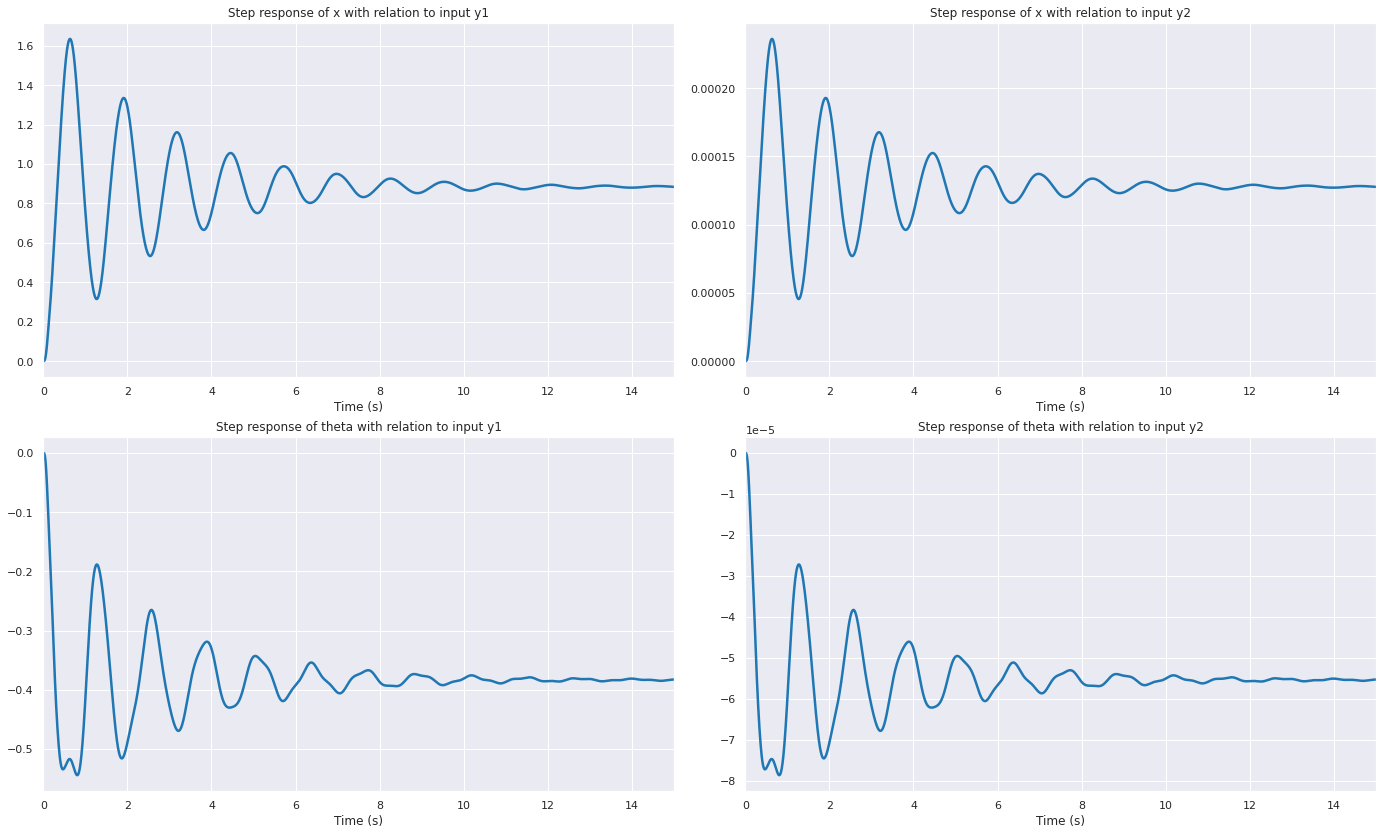

In [ ]:
#Para as entradas de deslocamento: 


B3 = G[:,0]
B4 = G[:,2]

TimeVector = np.linspace(0,15,5000)

sys1_q1y1 = control.ss(A, B3, C1, D0)
sys1_q2y1 = control.ss(A, B3, C2, D0)
sys1_q3y1 = control.ss(A, B3, C3, D0)
sys1_q4y1 = control.ss(A, B3, C4, D0)
sys1_q5y1 = control.ss(A, B3, C5, D0)
sys1_q6y1 = control.ss(A, B3, C6, D0)

sys1_q1y2 = control.ss(A, B4, C1, D0)
sys1_q2y2 = control.ss(A, B4, C2, D0)
sys1_q3y2 = control.ss(A, B4, C3, D0)
sys1_q4y2 = control.ss(A, B4, C4, D0)
sys1_q5y2 = control.ss(A, B4, C5, D0)
sys1_q6y2 = control.ss(A, B4, C6, D0)


#Respostas no tempo (x e theta) para uma entrada degrau de deslocamento em y. 
t_q1y1, yout_q1y1 = control.step_response(sys1_q1y1, T = TimeVector)
t_q2y1, yout_q2y1 = control.step_response(sys1_q2y1, T = TimeVector
t_q1y2, yout_q1y2 = control.step_response(sys1_q1y2, T = TimeVector)
t_q2y2, yout_q2y2 = control.step_response(sys1_q2y2, T = TimeVector)



fig, axs = plt.subplots(2,2, figsize=(20,12))
fig.tight_layout(pad = 3.0)

axs[0,0].plot(t_q1y1, yout_q1y1)
axs[0,0].set_title("Step response of x with relation to input y1")
axs[1,0].plot(t_q2y1, yout_q2y1)
axs[1,0].set_title("Step response of theta with relation to input y1")


axs[0,1].plot(t_q1y2, yout_q1y2)
axs[0,1].set_title("Step response of x with relation to input y2")
axs[1,1].plot(t_q2y2, yout_q2y2)
axs[1,1].set_title("Step response of theta with relation to input y2")


for xax in axs: 
  for ax in xax: 
    ax.set_xlabel('Time (s)')
    ax.set_xlim(0,15)






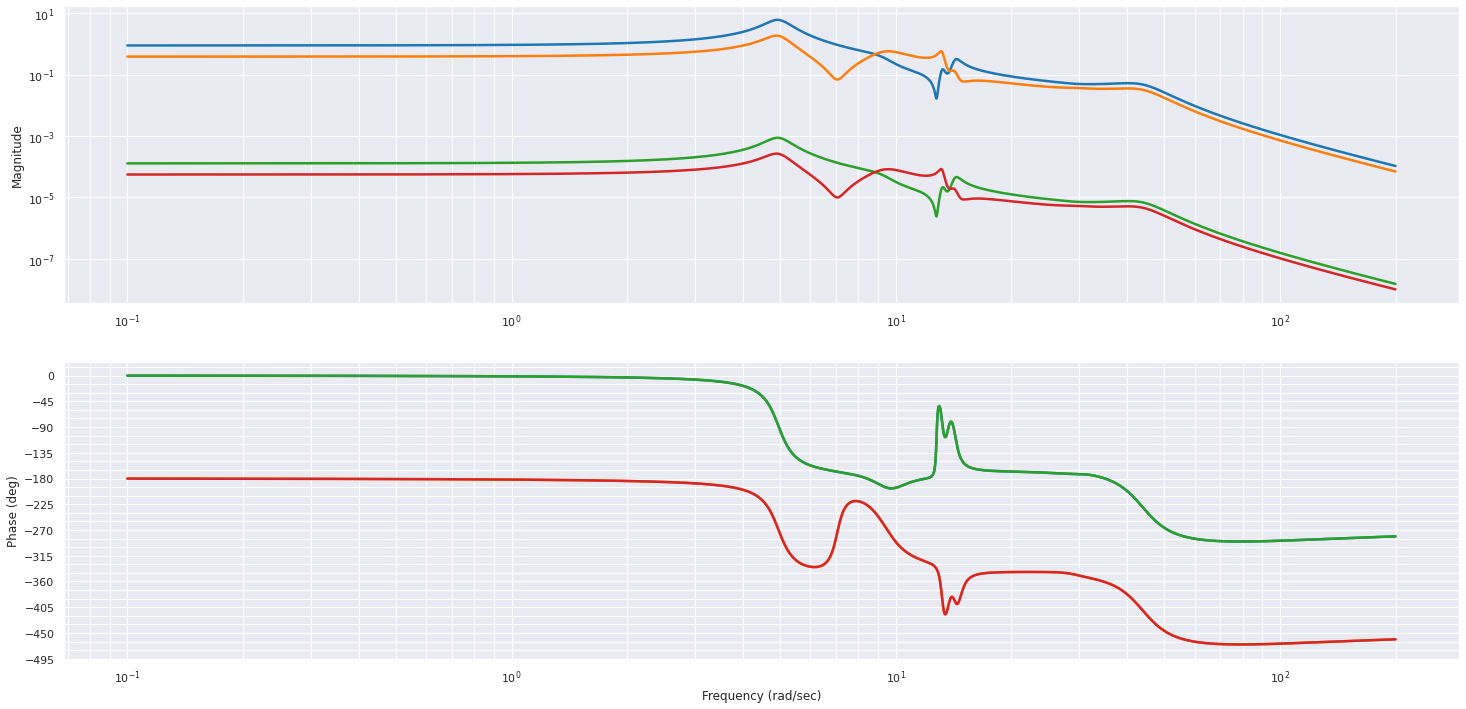

In [ ]:
#Diagrama de bode para x e theta em relação às entradas y1 e y2. 

plt.figure(figsize = (25,12))
mag, phase, omega = control.bode_plot(sys1_q1y1,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q2y1,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q1y2,omega = w, plot=True)
mag, phase, omega = control.bode_plot(sys1_q2y2,omega = w, plot=True)


In [ ]:



TimeVector = np.linspace(0,15,5000)

t_1f1, yout_1f1 = control.step_response(sys1_q1f1, T = TimeVector)
t_2f1, yout_2f1 = control.step_response(sys1_q2f1, T = TimeVector)
t_3f1, yout_3f1 = control.step_response(sys1_q3f1, T = TimeVector)
t_4f1, yout_4f1 = control.step_response(sys1_q4f1, T = TimeVector)
t_5f1, yout_5f1 = control.step_response(sys1_q5f1, T = TimeVector)
t_6f1, yout_6f1 = control.step_response(sys1_q6f1, T = TimeVector)

t_1f2, yout_1f2 = control.step_response(sys1_q1f2, T = TimeVector)
t_2f2, yout_2f2 = control.step_response(sys1_q2f2, T = TimeVector)
t_3f2, yout_3f2 = control.step_response(sys1_q3f2, T = TimeVector)
t_4f2, yout_4f2 = control.step_response(sys1_q4f2, T = TimeVector)
t_5f2, yout_5f2 = control.step_response(sys1_q5f2, T = TimeVector)
t_6f2, yout_6f2 = control.step_response(sys1_q6f2, T = TimeVector)






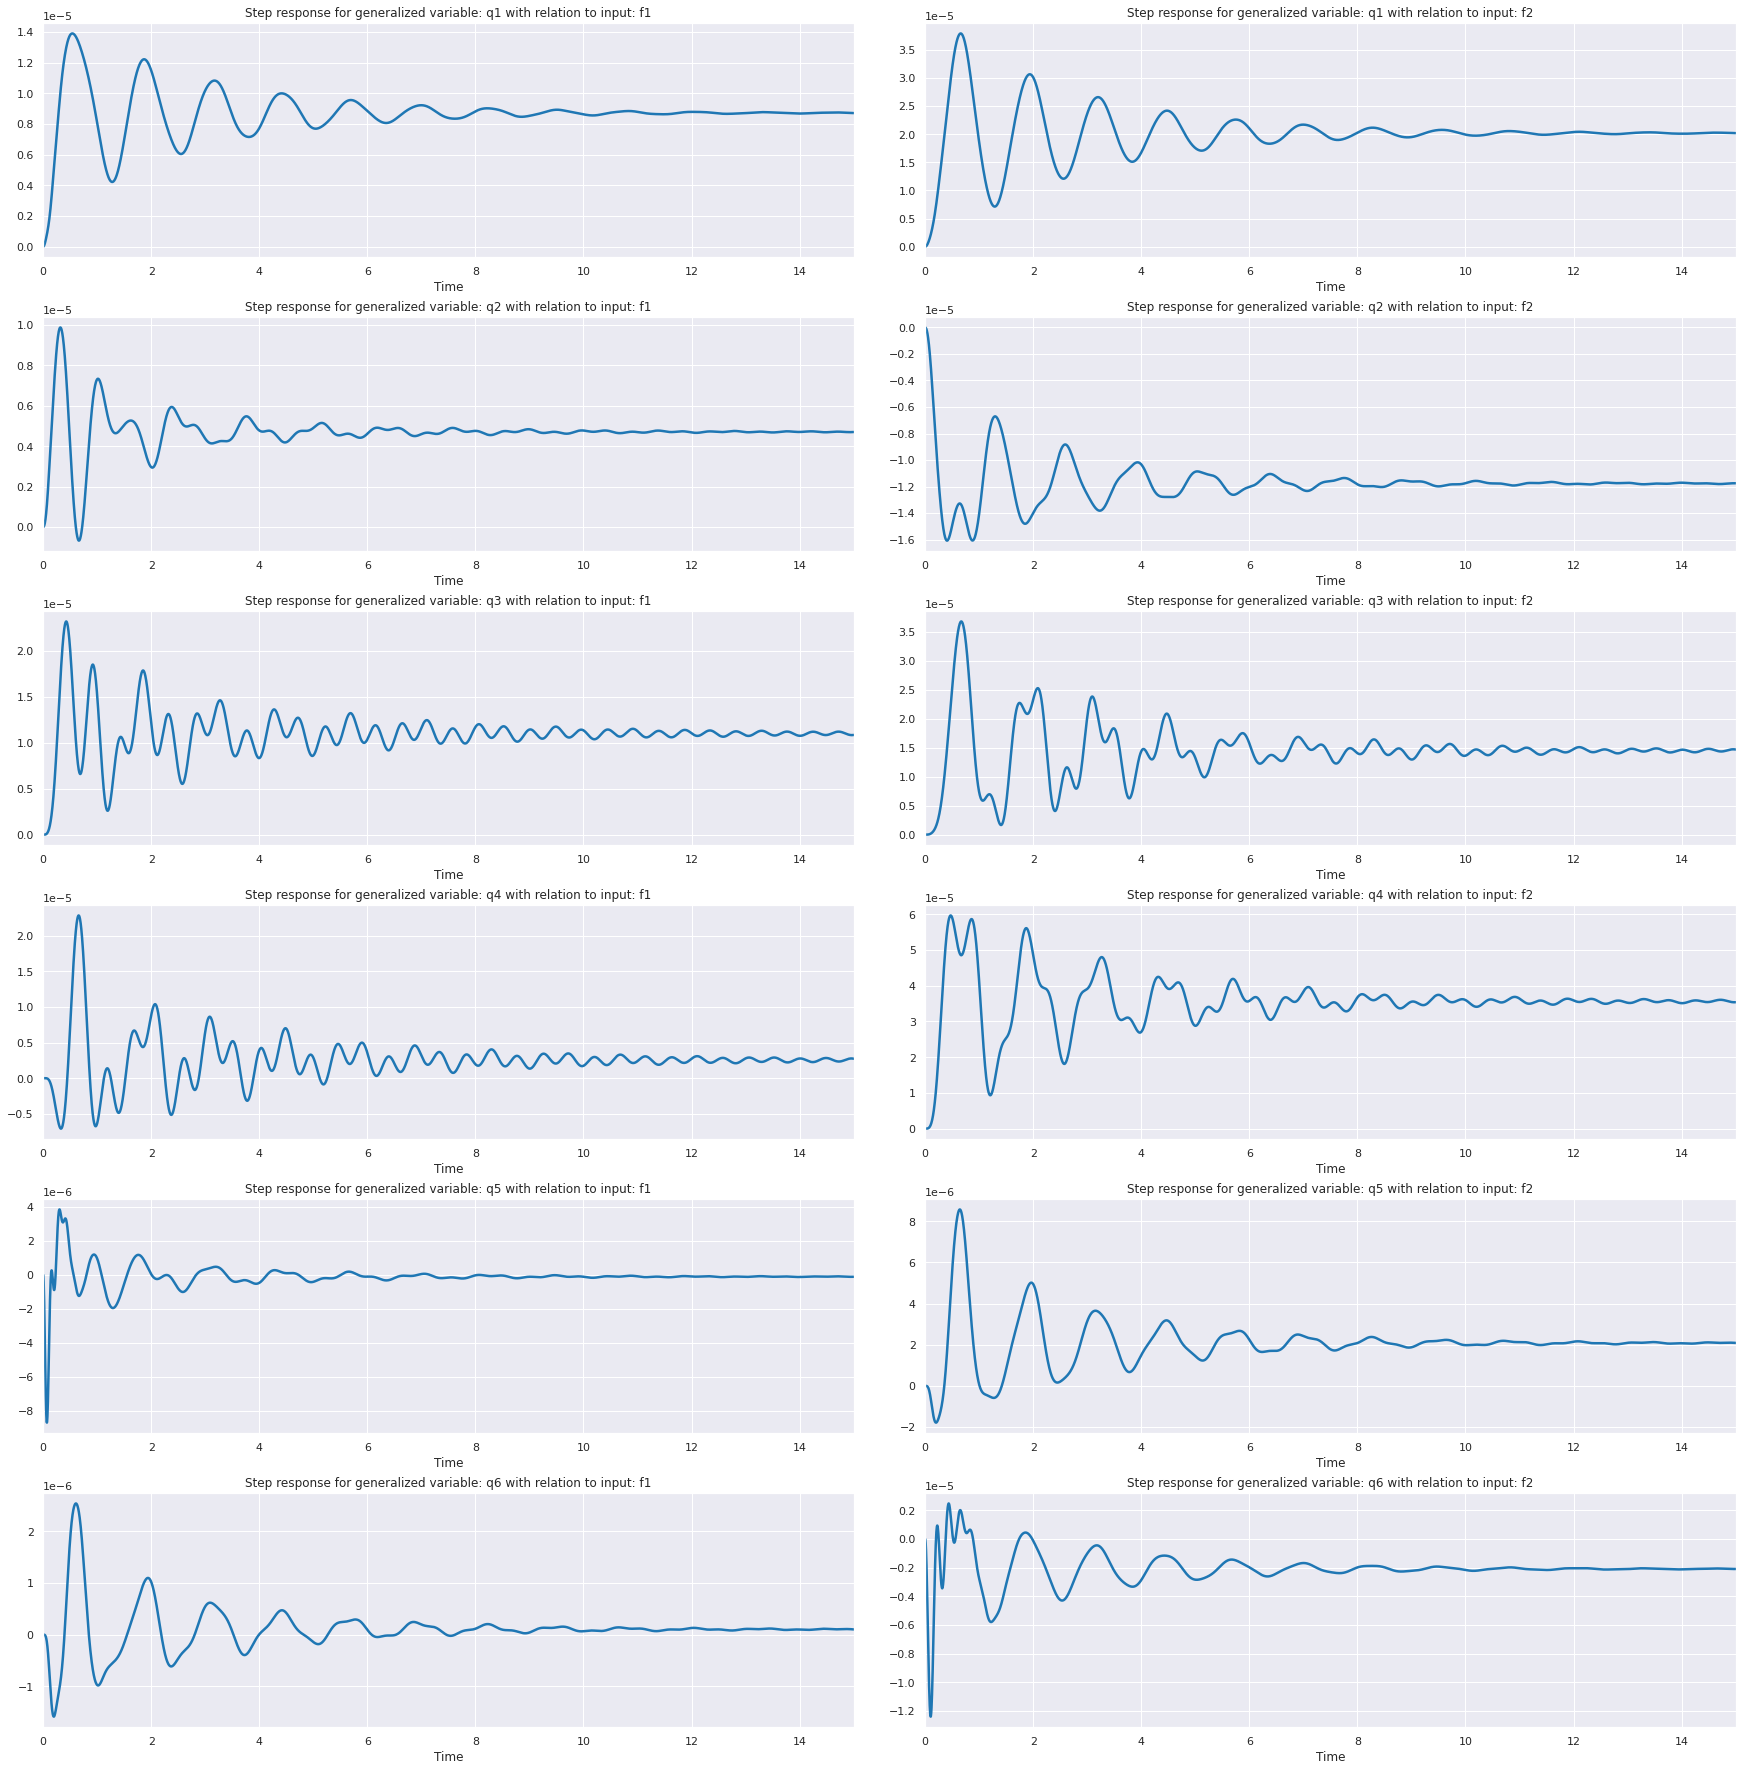

In [ ]:

#Gráficos dos valores de q1,...,q6 para entrada degrau de f1 e f2. 

fig, axs = plt.subplots(6, 2, figsize=(25,25))
fig.tight_layout(pad = 3.0)

axs[0,0].plot(t_1f1, yout_1f1)
axs[1,0].plot(t_2f1, yout_2f1)
axs[2,0].plot(t_3f1, yout_3f1)
axs[3,0].plot(t_4f1, yout_4f1)
axs[4,0].plot(t_5f1, yout_5f1)
axs[5,0].plot(t_6f1, yout_6f1)


axs[0,1].plot(t_1f2, yout_1f2)
axs[1,1].plot(t_2f2, yout_2f2)
axs[2,1].plot(t_3f2, yout_3f2)
axs[3,1].plot(t_4f2, yout_4f2)
axs[4,1].plot(t_5f2, yout_5f2)
axs[5,1].plot(t_6f2, yout_6f2)

col = 1
row = 0


for xax in axs: 
  row = 1
  for ax in xax: 
    ax.set_xlabel('Time')
    ax.set_xlim(0,15)
    ax.set_title(('Step response for generalized variable: q' + str(col) + " with relation to input: f" + str(row)))
    row = row + 1
  col = col + 1
